This notebook generates the train/val/test splits for the DHS survey-based datasets included in SustainBench.

In [1]:
import copy
import os

import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('output_labels/dhs_final_labels.csv')
display(df.head())

# get DHS clusters CSV from Yeh et al. (2020, Nature Communications)
df2020 = pd.read_csv('https://github.com/chrisyeh96/africa_poverty_clean/raw/main/data/dhs_clusters.csv')
display(df2020.head())

dhs_countries_api = "http://api.dhsprogram.com/rest/dhs/countries?returnFields=CountryName,DHS_CountryCode,ISO2_countryCode,ISO3_countryCode&f=csv"
dhs_countries_crosswalk = pd.read_csv(dhs_countries_api)
display(dhs_countries_crosswalk.head())

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,n_water,water_index,n_sanitation,...,under5_mort,n_under5_mort,women_edu,women_bmi,n_women_edu,n_women_bmi,cluster_id,adm1fips,adm1dhs,urban
0,AL-2008-5#-00000001,AL,2008,40.822652,19.838321,18.0,2.430596,18.0,3.444444,18.0,...,0.0,6.0,9.500000,24.365000,18.0,18.0,1,NaN,9999,R
1,AL-2008-5#-00000002,AL,2008,40.696846,20.007555,20.0,2.867678,20.0,4.700000,20.0,...,NaN,NaN,8.600000,23.104000,20.0,20.0,2,NaN,9999,R
2,AL-2008-5#-00000003,AL,2008,40.750037,19.974262,18.0,2.909049,18.0,4.500000,18.0,...,NaN,NaN,9.666667,22.387778,18.0,18.0,3,NaN,9999,R
3,AL-2008-5#-00000004,AL,2008,40.798931,19.863338,19.0,2.881122,19.0,4.947368,19.0,...,NaN,NaN,9.952381,27.084500,21.0,20.0,4,NaN,9999,R
4,AL-2008-5#-00000005,AL,2008,40.746123,19.843885,19.0,2.546830,19.0,4.684211,19.0,...,0.0,6.0,8.937500,24.523125,16.0,16.0,5,NaN,9999,R


,country,year,lat,lon,GID_1,GID_2,wealthpooled,households,urban_rural
0,angola,2011,-12.350257,13.534922,AGO.2,AGO.2.9,2.595618,36,1
1,angola,2011,-12.360865,13.551494,AGO.2,AGO.2.9,2.209620,32,1
2,angola,2011,-12.613421,13.413085,AGO.2,AGO.2.3,0.906469,36,1
3,angola,2011,-12.581454,13.397711,AGO.2,AGO.2.3,1.105359,35,1
4,angola,2011,-12.578135,13.418748,AGO.2,AGO.2.3,1.879344,37,1


,CountryName,DHS_CountryCode,ISO2_CountryCode,ISO3_CountryCode
0,Afghanistan,AF,AF,AFG
1,Albania,AL,AL,ALB
2,Angola,AO,AO,AGO
3,Armenia,AM,AM,ARM
4,Azerbaijan,AZ,AZ,AZE


In [3]:
for x in [df, df2020]:
    for col in ['lat', 'lon']:
        x[col + '32'] = x[col].astype(np.float32)

In [4]:
df2020['iso3'] = df2020['GID_1'].str[:3]
df2020 = df2020.merge(
    dhs_countries_crosswalk[['DHS_CountryCode', 'ISO3_CountryCode']],
    left_on='iso3', right_on='ISO3_CountryCode')
df2020.rename(columns={'DHS_CountryCode': 'dhs_cc'}, inplace=True)

In [5]:
df_subset = df.loc[
    df['cname'].isin(df2020['dhs_cc'].unique()) &
    (df['year'] >= 2009) &
    (df['year'] <= 2017)
]

In [6]:
merged = df_subset.merge(df2020, on=['lat32', 'lon32'], how='inner', validate='1:1')
merged

,DHSID_EA,cname,year_x,lat_x,lon_x,n_asset,asset_index,n_water,water_index,n_sanitation,...,lat_y,lon_y,GID_1,GID_2,wealthpooled,households,urban_rural,iso3,dhs_cc,ISO3_CountryCode
0,AO-2011-6#-00000001,AO,2011,-12.350257,13.534922,36.0,3.473384,36.0,5.000000,36.0,...,-12.350257,13.534922,AGO.2,AGO.2.9,2.595618,36,1,AGO,AO,AGO
1,AO-2011-6#-00000002,AO,2011,-12.360865,13.551494,32.0,2.944854,32.0,5.000000,32.0,...,-12.360865,13.551494,AGO.2,AGO.2.9,2.209620,32,1,AGO,AO,AGO
2,AO-2011-6#-00000003,AO,2011,-12.613421,13.413085,36.0,0.542230,36.0,5.000000,36.0,...,-12.613421,13.413085,AGO.2,AGO.2.3,0.906469,36,1,AGO,AO,AGO
3,AO-2011-6#-00000004,AO,2011,-12.581454,13.397711,35.0,0.870752,35.0,4.885714,35.0,...,-12.581454,13.397711,AGO.2,AGO.2.3,1.105359,35,1,AGO,AO,AGO
4,AO-2011-6#-00000005,AO,2011,-12.578135,13.418748,37.0,2.143655,37.0,5.000000,37.0,...,-12.578135,13.418748,AGO.2,AGO.2.3,1.879344,37,1,AGO,AO,AGO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19664,ZW-2015-7#-00000396,ZW,2015,-17.915288,31.156115,24.0,1.094416,24.0,3.875000,24.0,...,-17.915288,31.156115,ZWE.2,ZWE.2.1,0.237659,24,1,ZWE,ZW,ZWE
19665,ZW-2015-7#-00000397,ZW,2015,-18.379501,31.872287,25.0,0.506343,25.0,3.800000,25.0,...,-18.379501,31.872287,ZWE.3,ZWE.3.4,0.492502,25,0,ZWE,ZW,ZWE
19666,ZW-2015-7#-00000398,ZW,2015,-16.660612,29.850649,28.0,-1.125132,28.0,2.714286,28.0,...,-16.660612,29.850649,ZWE.6,ZWE.6.2,-0.088922,28,0,ZWE,ZW,ZWE
19667,ZW-2015-7#-00000399,ZW,2015,-17.914251,30.956975,25.0,2.217437,25.0,3.560000,25.0,...,-17.914251,30.956975,ZWE.2,ZWE.2.1,1.613829,25,1,ZWE,ZW,ZWE


In [7]:
import matplotlib.pyplot as plt

In [8]:
merged[merged['asset_index'].isna()]

,DHSID_EA,cname,year_x,lat_x,lon_x,n_asset,asset_index,n_water,water_index,n_sanitation,...,lat_y,lon_y,GID_1,GID_2,wealthpooled,households,urban_rural,iso3,dhs_cc,ISO3_CountryCode
6665,KE-2014-7#-00000777,KE,2014,2.639338,40.680457,NaN,NaN,5.0,2.4,5.0,...,2.639338,40.680457,KEN.24,KEN.24.5,-0.916851,4,0,KEN,KE,KEN
18727,ZM-2013-6#-00000574,ZM,2013,-9.543637,32.371436,NaN,NaN,NaN,NaN,NaN,...,-9.543637,32.371436,ZMB.6,ZMB.6.5,-0.582429,4,0,ZMB,ZM,ZMB


In [9]:
merged[merged['households'] < 5]

,DHSID_EA,cname,year_x,lat_x,lon_x,n_asset,asset_index,n_water,water_index,n_sanitation,...,lat_y,lon_y,GID_1,GID_2,wealthpooled,households,urban_rural,iso3,dhs_cc,ISO3_CountryCode
6665,KE-2014-7#-00000777,KE,2014,2.639338,40.680457,NaN,NaN,5.0,2.4,5.0,...,2.639338,40.680457,KEN.24,KEN.24.5,-0.916851,4,0,KEN,KE,KEN
18727,ZM-2013-6#-00000574,ZM,2013,-9.543637,32.371436,NaN,NaN,NaN,NaN,NaN,...,-9.543637,32.371436,ZMB.6,ZMB.6.5,-0.582429,4,0,ZMB,ZM,ZMB


In [10]:
merged_notna = merged[merged['asset_index'].notna()]

In [11]:
import scipy.stats
r = scipy.stats.pearsonr(merged_notna['asset_index'], merged_notna['wealthpooled'])[0]
print('r:', r, 'r^2:', r**2)

r: 0.9534067040013039 r^2: 0.90898434323463


Text(0, 0.5, 'NatComms asset index')

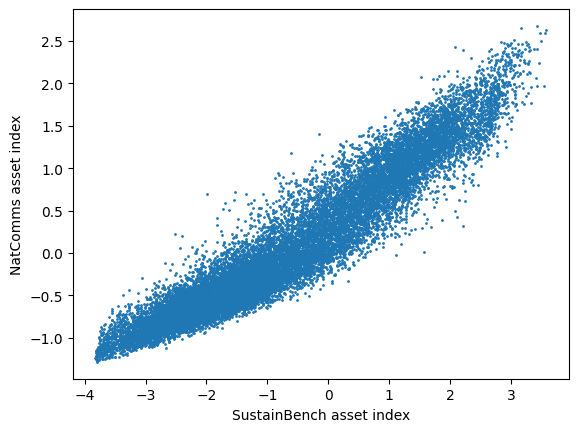

In [12]:
fig, ax = plt.subplots(1, 1)
ax.scatter(merged_notna['asset_index'], merged_notna['wealthpooled'], s=1)
ax.set_xlabel('SustainBench asset index')
ax.set_ylabel('NatComms asset index')

In [13]:
FOLDS_2020 = {
    'A': ['angola', 'cote_d_ivoire', 'ethiopia', 'mali', 'rwanda'],
    'B': ['benin', 'burkina_faso', 'guinea', 'sierra_leone', 'tanzania'],
    'C': ['cameroon', 'ghana', 'malawi', 'zimbabwe'],
    'D': ['democratic_republic_of_congo', 'mozambique', 'nigeria', 'togo', 'uganda'],
    'E': ['kenya', 'lesotho', 'senegal', 'zambia'],
}

In [14]:
cname2020_to_dhscc = dict(df2020.groupby(['country', 'dhs_cc']).groups.keys())
display(cname2020_to_dhscc)

{'angola': 'AO',
 'benin': 'BJ',
 'burkina_faso': 'BF',
 'cameroon': 'CM',
 'cote_d_ivoire': 'CI',
 'democratic_republic_of_congo': 'CD',
 'ethiopia': 'ET',
 'ghana': 'GH',
 'guinea': 'GN',
 'kenya': 'KE',
 'lesotho': 'LS',
 'malawi': 'MW',
 'mali': 'ML',
 'mozambique': 'MZ',
 'nigeria': 'NG',
 'rwanda': 'RW',
 'senegal': 'SN',
 'sierra_leone': 'SL',
 'tanzania': 'TZ',
 'togo': 'TG',
 'uganda': 'UG',
 'zambia': 'ZM',
 'zimbabwe': 'ZW'}

In [15]:
FOLDS_2020_dhscc = {
    f: [cname2020_to_dhscc[c] for c in countries]
    for f, countries in FOLDS_2020.items()
}
display(FOLDS_2020_dhscc)

{'A': ['AO', 'CI', 'ET', 'ML', 'RW'],
 'B': ['BJ', 'BF', 'GN', 'SL', 'TZ'],
 'C': ['CM', 'GH', 'MW', 'ZW'],
 'D': ['CD', 'MZ', 'NG', 'TG', 'UG'],
 'E': ['KE', 'LS', 'SN', 'ZM']}

In [16]:
# get a sense of existing fold sizes
FOLDS_2020_sizes = {
    f: df['cname'].isin(dhscc_codes).sum()
    for f, dhscc_codes in FOLDS_2020_dhscc.items()
}
print(FOLDS_2020_sizes)

{'A': 7708, 'B': 9219, 'C': 8010, 'D': 9409, 'E': 7389}


In [17]:
FOLDS = copy.deepcopy(FOLDS_2020_dhscc)
FOLDS_sizes = copy.deepcopy(FOLDS_2020_sizes)

In [18]:
remaining_dhscc = set(df['cname'].unique())
for cc_list in FOLDS_2020_dhscc.values():
    remaining_dhscc -= set(cc_list)
print(remaining_dhscc)

{'AM', 'EG', 'TJ', 'PE', 'BU', 'MD', 'CO', 'MB', 'SZ', 'NM', 'NP', 'TD', 'HN', 'BD', 'MA', 'KY', 'PK', 'LB', 'KH', 'HT', 'GY', 'PH', 'AL', 'NI', 'ID', 'MM', 'DR', 'GA', 'GU', 'BO', 'IA', 'KM', 'JO'}


In [19]:
sizes = df.groupby('cname').size()
sizes.loc[sorted(remaining_dhscc)].head()

cname
AL    1161
AM     621
BD    2931
BO     997
BU    1128
dtype: int64

In [20]:
while len(remaining_dhscc) > 0:
    top_cc = sizes.loc[list(remaining_dhscc)].idxmax()
    top_size = sizes.loc[top_cc]
    smallest_fold = min(FOLDS_sizes, key=FOLDS_sizes.get)
    FOLDS[smallest_fold].append(top_cc)
    FOLDS_sizes[smallest_fold] += top_size
    remaining_dhscc.remove(top_cc)

In [21]:
print(FOLDS)

{'A': ['AO', 'CI', 'ET', 'ML', 'RW', 'EG', 'KH', 'PK', 'NP', 'BU', 'AM', 'KY', 'SZ'], 'B': ['BJ', 'BF', 'GN', 'SL', 'TZ', 'CO', 'DR', 'HT', 'NM', 'BO', 'TD', 'GA', 'GY'], 'C': ['CM', 'GH', 'MW', 'ZW', 'PE', 'PH', 'LB', 'AL', 'GU', 'TJ', 'MB', 'NI'], 'D': ['CD', 'MZ', 'NG', 'TG', 'UG', 'JO', 'BD', 'MD', 'ID', 'HN', 'MA', 'MM', 'KM'], 'E': ['KE', 'LS', 'SN', 'ZM', 'IA']}


In [22]:
print(FOLDS_sizes)

{'A': 20860, 'B': 20890, 'C': 20890, 'D': 20868, 'E': 34136}


In [23]:
SPLITS = {
    'train': sorted(FOLDS['C'] + FOLDS['D'] + FOLDS['E']),
    'val':   sorted(FOLDS['B']),
    'test':  sorted(FOLDS['A'])
}
print(SPLITS)

{'train': ['AL', 'BD', 'CD', 'CM', 'GH', 'GU', 'HN', 'IA', 'ID', 'JO', 'KE', 'KM', 'LB', 'LS', 'MA', 'MB', 'MD', 'MM', 'MW', 'MZ', 'NG', 'NI', 'PE', 'PH', 'SN', 'TG', 'TJ', 'UG', 'ZM', 'ZW'], 'val': ['BF', 'BJ', 'BO', 'CO', 'DR', 'GA', 'GN', 'GY', 'HT', 'NM', 'SL', 'TD', 'TZ'], 'test': ['AM', 'AO', 'BU', 'CI', 'EG', 'ET', 'KH', 'KY', 'ML', 'NP', 'PK', 'RW', 'SZ']}


In [24]:
for label in ['asset_index', 'under5_mort', 'women_bmi', 'women_edu', 'water_index', 'sanitation_index']:
    print(f'{label:17s}', {
        split: len(df[df[label].notna() & df['cname'].isin(SPLITS[split])])
        for split in ['train', 'val', 'test']
    })

asset_index       {'train': 59617, 'val': 16776, 'test': 10543}
under5_mort       {'train': 69052, 'val': 17062, 'test': 19468}
women_bmi         {'train': 61950, 'val': 15675, 'test': 17241}
women_edu         {'train': 75818, 'val': 20589, 'test': 20655}
water_index       {'train': 59620, 'val': 17773, 'test': 10545}
sanitation_index  {'train': 60184, 'val': 16776, 'test': 12311}


In [25]:
# calculate size of each split in %
for label in ['asset_index', 'under5_mort', 'women_bmi', 'women_edu', 'water_index', 'sanitation_index']:
    print(f'{label:17s}', {
        split: round(len(df[df[label].notna() & df['cname'].isin(SPLITS[split])]) / len(df[df[label].notna()]), 2)
        for split in ['train', 'val', 'test']
    })

asset_index       {'train': 0.69, 'val': 0.19, 'test': 0.12}
under5_mort       {'train': 0.65, 'val': 0.16, 'test': 0.18}
women_bmi         {'train': 0.65, 'val': 0.17, 'test': 0.18}
women_edu         {'train': 0.65, 'val': 0.18, 'test': 0.18}
water_index       {'train': 0.68, 'val': 0.2, 'test': 0.12}
sanitation_index  {'train': 0.67, 'val': 0.19, 'test': 0.14}


In [28]:
df.columns

Index(['DHSID_EA', 'cname', 'year', 'lat', 'lon', 'n_asset', 'asset_index',
       'n_water', 'water_index', 'n_sanitation', 'sanitation_index',
       'under5_mort', 'n_under5_mort', 'women_edu', 'women_bmi', 'n_women_edu',
       'n_women_bmi', 'cluster_id', 'adm1fips', 'adm1dhs', 'urban', 'lat32',
       'lon32'],
      dtype='object')